# IR-MLP

In [1]:
skip_training = False  # Set this flag to True before validation and submission

In [2]:
# During evaluation, this cell sets skip_training to True

import tools, warnings
warnings.showwarning = tools.customwarn

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F


In [4]:
# When running on your own computer, you can specify the data directory by:
# data_dir = tools.select_data_dir('/your/local/data/directory')
data_dir = tools.select_data_dir()

The data directory is ../data


In [5]:
# Select device which you are going to use for training
#device = torch.device("cuda:0")
device = torch.device("cpu")

In [6]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device("cpu")

### Input preprocessing

Spatio-temporal coordinate are mapped to a high dimensional space using Fourier features with $L=10$. 

$$\gamma(p) = \{ \sin(2^l \pi p), \cos(2^l \pi p); 0 \leq l < L \}$$
$$ p := (x,y,z,t)$$


In [7]:
def fourier_features_mapping(p, L):
    """ Computes Fourier features as defined in the paper. B may be changed later on.
    Args:
        p of shape (batch_size, p[0]_dim): raw tensor 
    Returns:
        x_out of shape (batch_size, 1, p_dim.shape[1]*2*L) : fourier features of p
    """
    B = torch.tensor([np.pi*2**l for l in range(L)])
    B = B[None, :]
    x_out = torch.empty(p.shape[0], 1, 2*L*p.shape[1])
    
    for i,x in enumerate(p):
        x_proj = x[:,None] * B
        x_out[i] = torch.reshape(torch.cat([torch.sin(x_proj), torch.cos(x_proj)], axis=-1), (1,-1))
#     print(x_out.shape)
    return x_out

In [8]:
# ### Testing
# fs=48000
# t = torch.tensor([[5],[6],[40000]])/fs
# t = fourier_features_mapping(t,10)
# # print(f'T_map shape: {t.shape}')
# # print(t)
# p = torch.tensor([[2,3,5],[4,4,6]])/6
# p = fourier_features_mapping(p,10)
# # print(f'T_map shape: {p.shape}')
# # print(p)
# b = t
# batch_size = p.shape[0]
# time_len = b.shape[0]
# b = np.swapaxes(b, 0,1)
# b = np.repeat(b, batch_size, axis=0)

# a = p
# a = np.repeat(a, time_len, axis=1)
# out = np.concatenate((a,b), axis=-1)
# # print(out.shape)

In [9]:
L = 10
# FS = 48000
# sec = 3
# IR_len = FS*sec
# from torch.nn.utils.rnn import pad_sequence

### may have to deal with differing sample rates later. 
def collate(list_of_samples):
    """Merges a list of samples to form a mini-batch.

    Args:
      list_of_samples is a list of tuples (p, tgt_seq) of length batch_size:
          p is tensor of shape (3)
          tgt_seq is tensor of shape (IR_len)

    Returns:
      pt of shape (batch_size, max_tgt_seq_length, input_mapped_dim): LongTensor of padded source sequences.
      tgt of shape (batch_size, IR_len): LongTensor of padded target sequences.
    """
#     p, tgt_seqs = map(list, zip(*list_of_samples))
    p, tgt_seqs = zip(*list_of_samples)
    batch_size = len(p)
    IR_len = len(tgt_seqs[0])

    # calculate Fourier features for positions
    p = torch.stack(p)
    p = fourier_features_mapping(p, L)
    p = np.repeat(p, IR_len, axis=1)
    
    # calculate Fourier features for time
    t = fourier_features_mapping(torch.reshape(torch.arange(0, IR_len), (-1,1))/FS, L)
    t = np.repeat(np.swapaxes(t, 0,1), batch_size, axis=0)
    
    pt = torch.cat((p,t), axis=-1)
#     tgt = pad_sequence(tgt_seqs, batch_first=True)
    
    tgt = torch.stack(tgt_seqs)
    assert tgt.shape == torch.Size([len(tgt_seqs),IR_len]), f'Input tgt_sequence incorrect length: {tgt.shape}'

    return pt, tgt

In [10]:
def test_collate_fn():
    pairs = [
        (torch.tensor([1,2,3]), torch.randn(IR_len)),
        (torch.tensor([2,1,0]), torch.randn(IR_len)),
        (torch.tensor([6,3,7]), torch.randn(IR_len)),
    ]
#     pairs = [
#         (np.array([1,2,3]), np.random.rand(IR_len)),
#         (np.array([2,1,0]), np.random.rand(IR_len)),
#         (np.array([6,3,7]), np.random.rand(IR_len)),
#     ]
    pt, tgt = collate(pairs)
    assert pt.shape == torch.Size([3, FS*sec, 80]), f"Bad pt.shape: {pt.shape}"
#     assert pt.dtype == torch.long
    assert tgt.shape == torch.Size([3, FS*sec]), f"Bad tgt.shape: {tgt.shape}"
#     assert tgt.dtype == torch.long, f"Bad tgt.dtype: {tgt.dtype}"
    print('Success')

# test_collate_fn()

In [58]:
from IPython.display import Audio, display

In [59]:
framerate = 44100
t = np.linspace(0,5,framerate*5)
data = np.sin(2*np.pi*220*t) + np.sin(2*np.pi*224*t)
Audio(data, rate=framerate)

## Data

C:\Users\jacki\anaconda3\envs\Thesis\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
../data\MeshRIR
<_io.TextIOWrapper name='../data\\MeshRIR\\S32-M1_posSrc.npy' mode='r' encoding='cp1252'>
Resampling waveform from  48000  to  16000
torch.Size([1, 32768])
torch.Size([1, 10923])


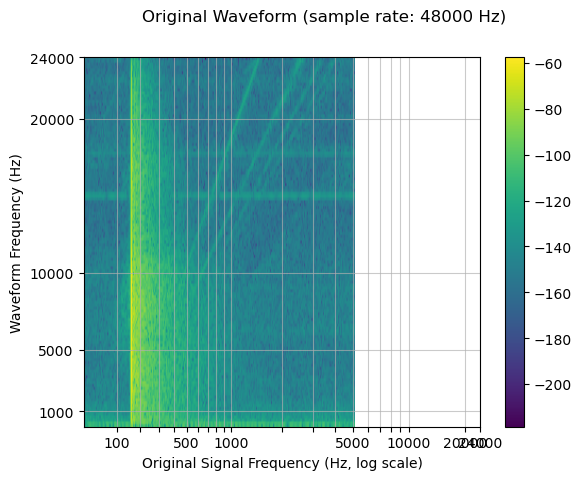

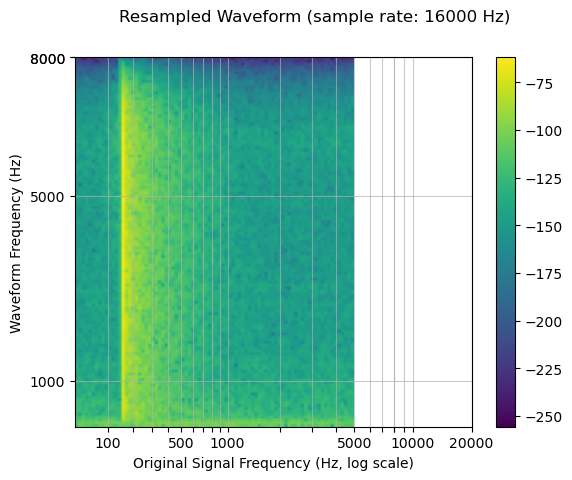

In [11]:
from data import MeshRIRDataset_S32_M1
trainset = MeshRIRDataset_S32_M1(root=data_dir, train=True, resample=16000)

In [12]:
FS = trainset.sample_rate
sec = None
IR_len = trainset.ir_len
print(FS)
print(IR_len)
print(trainset.y.shape)

16000
10923
torch.Size([32, 10923])


In [13]:
trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=1, collate_fn=collate, shuffle=True)

In [ ]:
testset = TranslationDataset(data_dir, train=False)
testloader = DataLoader(dataset=testset, batch_size=64, shuffle=False, collate_fn=collate)

(10923,)
torch.Size([10923])


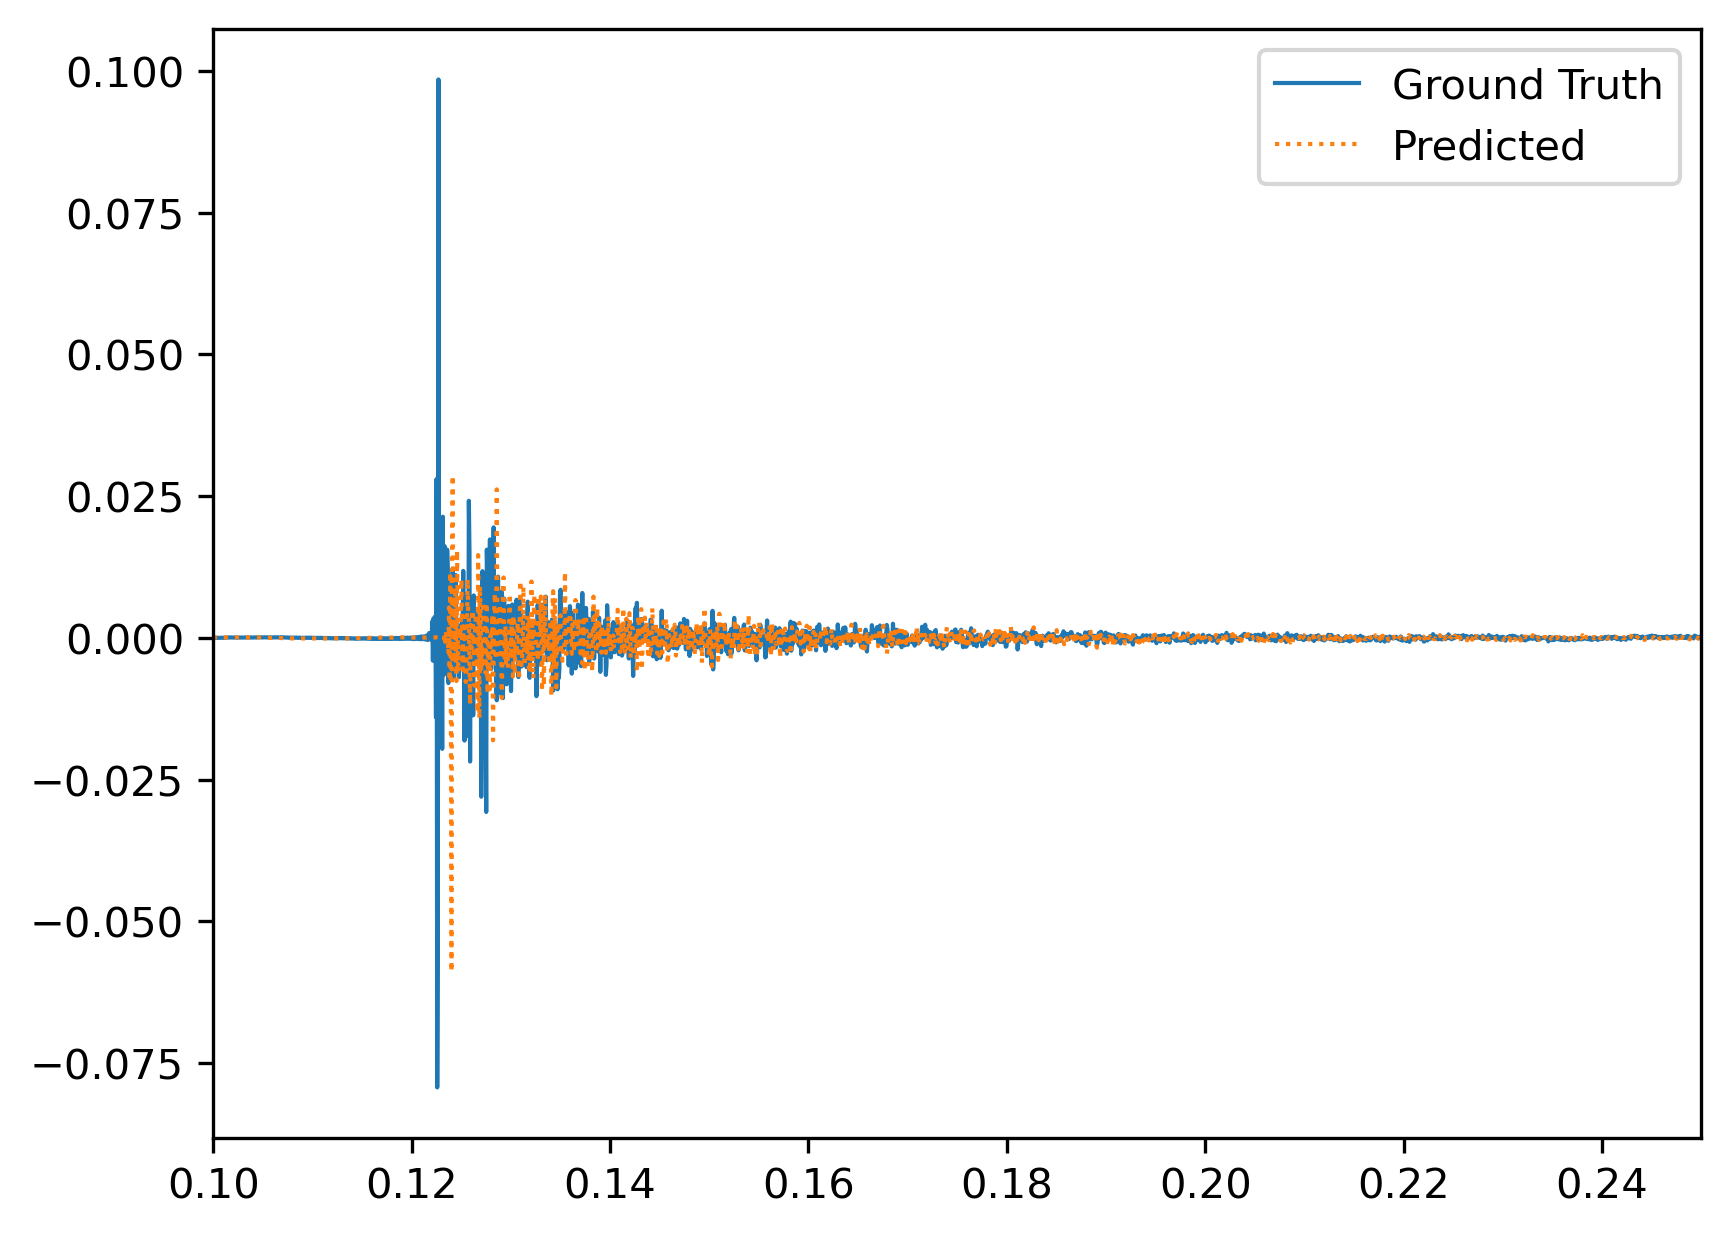

In [63]:
pos_sample, tgt_sample = trainset[np.random.choice(len(trainset))]
_, tgt_pred = trainset[np.random.choice(len(trainset))]

# tgt_pred = torch.randn(IR_len)

import matplotlib.pyplot as plt
time_scale = np.linspace(0,IR_len/FS, IR_len)
print(time_scale.shape)
print(tgt_sample.shape)
#Plot the data 
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

fig, ax = plt.subplots(1)
ax.plot(time_scale, tgt_sample, time_scale, tgt_pred, ':', linewidth=1)
# ax.plot(time_scale, tgt_sample)
ax.legend(['Ground Truth', 'Predicted'])
plt.xlim([0.1, 0.25])
# plt.savefig('test_matplotlib.png', bbox_inches="tight")
plt.show()

In [65]:
Audio(tgt_sample, rate=trainset.sample_rate)

In [67]:
Audio(tgt_pred, rate=trainset.sample_rate)

# Architecture

The architecture reported in the paper is listed here:  
1. full model: fully connected layers=6, hidden size=512, leaky ReLU
2. lightweight model: fully connected layers=6, hidden size=32

Architecture here:
- linear layer (input size, hidden size) + Leaky ReLU 
- linear layer (hidden size, hidden size) + Leaky ReLU 
- linear layer (hidden size, hidden size) + Leaky ReLU 
- linear layer (hidden size, hidden size) + Leaky ReLU 
- linear layer (hidden size, hidden size) + Leaky ReLU 
- linear layer (hidden size, hidden size) + Leaky ReLU 
- linear layer (hidden size, 1)


In [42]:
class IRMLP(nn.Module):
    def __init__(self, num_layers,input_size,hidden_size,negative_slope=0.01):
        super(IRMLP,self).__init__()
        
        linear_stack = [nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU(negative_slope)
        )]
        for _ in range(num_layers-1):
            linear_stack.extend([nn.Linear(hidden_size,hidden_size), nn.LeakyReLU(negative_slope)])
        self.fcn = nn.ModuleList(linear_stack)
        self.output_layer = nn.Linear(hidden_size,1, bias=False)
        
    def forward(self, x):
        """
        Args:
            x of shape (batch_size*IR_len, input_mapped_dim = 4*2*10 = 80): 
            Tensor with transformed input position vectors.
        
        Returns:
            h_t of shape (batch_size, 1): value for time step t
            
        """
        out = x
        for layer in self.fcn:
            out = layer(out)
        h_t = self.output_layer(out)
#         h_t = h_t.to(torch.long)
        return h_t

### Training
Initialize the IR-MLP model, then train.

In [55]:
num_layers = 6
input_size = 4*20
hidden_size = 32

model = IRMLP(num_layers, input_size, hidden_size).to(device)
print(model)

IRMLP(
  (fcn): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=80, out_features=32, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Linear(in_features=32, out_features=32, bias=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Linear(in_features=32, out_features=32, bias=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Linear(in_features=32, out_features=32, bias=True)
    (10): LeakyReLU(negative_slope=0.01)
  )
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
)


Epoch 0. Loss: 2725454.825
Epoch 1. Loss: 314534.1377929688
Epoch 2. Loss: 28664.931298828124


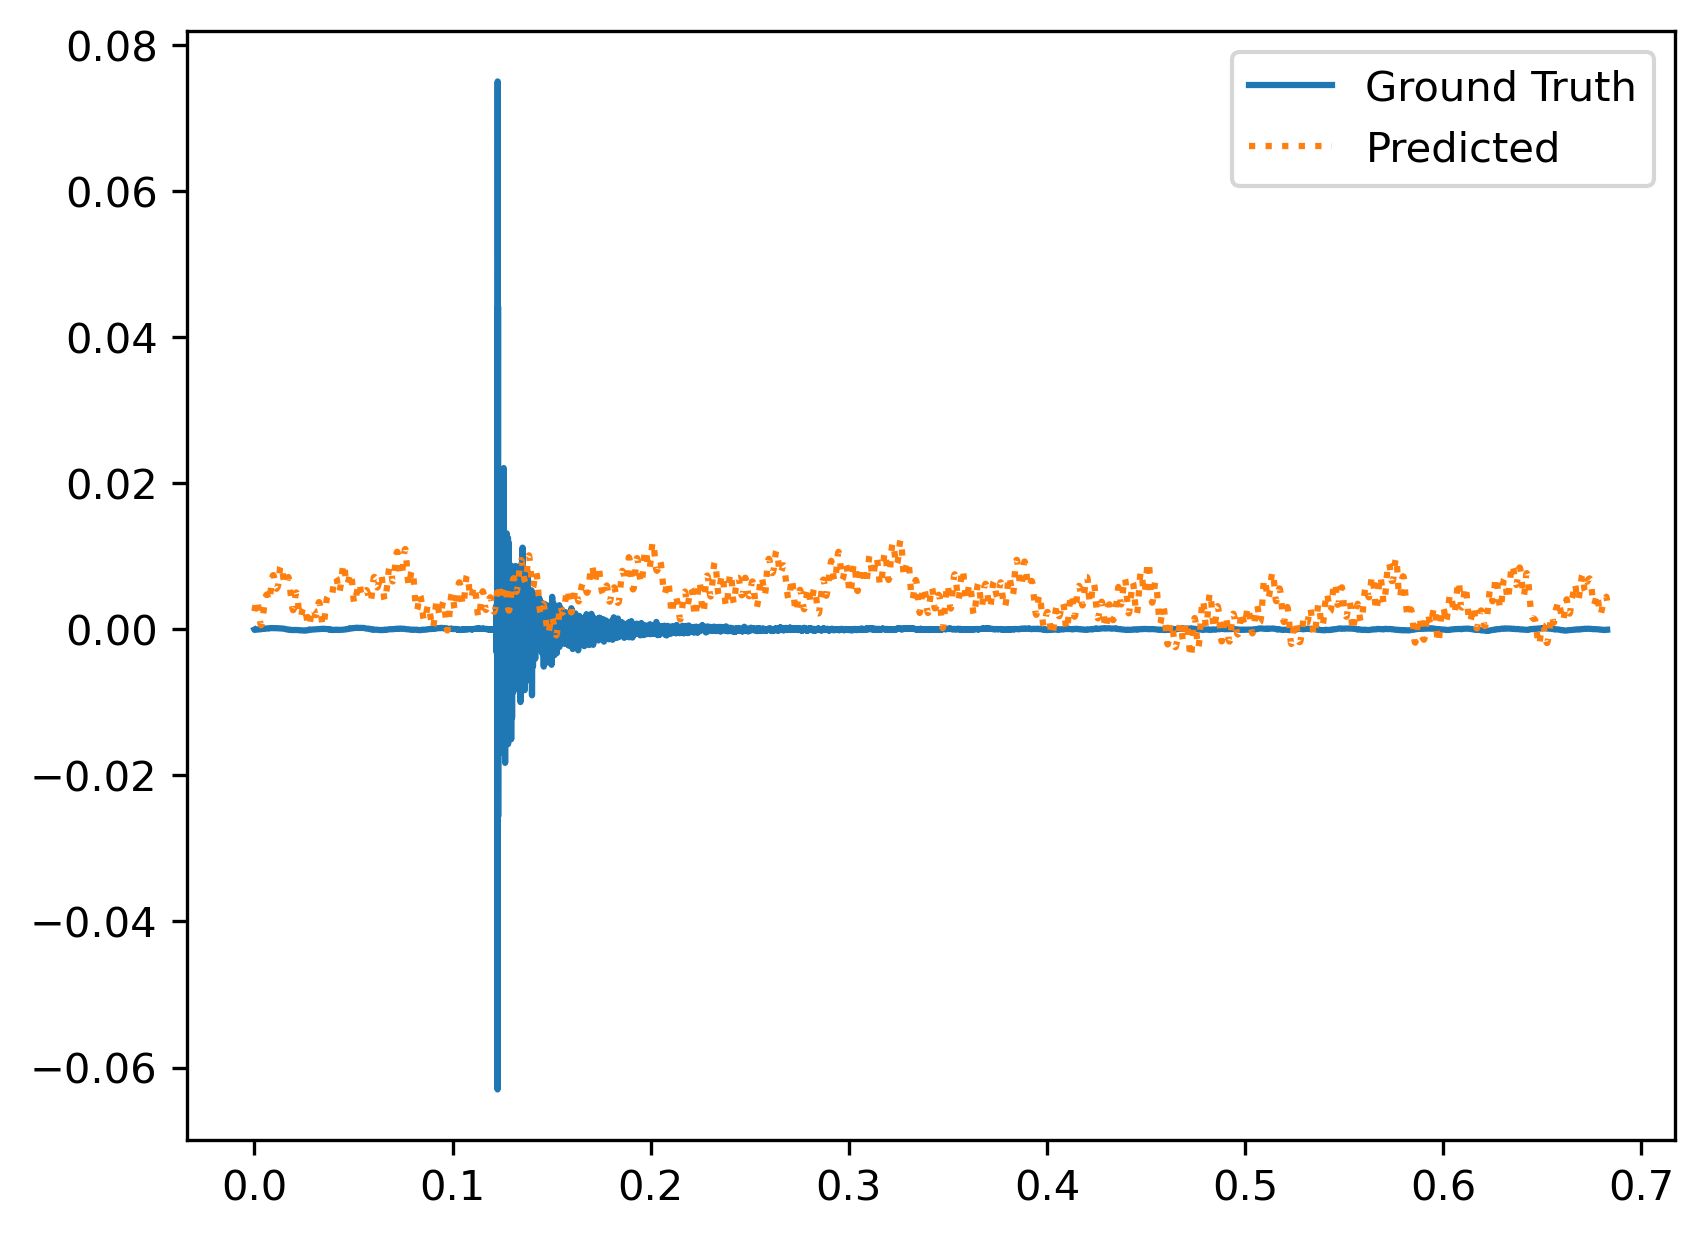

In [56]:
if not skip_training:
    EPOCHS = 3
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    criterion = nn.MSELoss(reduction='sum')

    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for x, y in trainloader:
            x = x.view(-1, x.shape[-1])
            y = y.to(torch.float32)
            out = model(x)
            
            # Zero gradient of optimizer:
            optimizer.zero_grad()
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch}. Loss: {total_loss/len(trainloader)/IR_len}")
    with torch.no_grad():
        model.eval()
        pt, tgt_gt = collate([trainset[np.random.choice(len(trainset))]])
        tgt_pred = model(pt)
#         print(tgt_gt.shape)
#         print(tgt_pred.shape)
#         print(F.mse_loss(tgt_pred, tgt_gt))
        tgt_gt = tgt_gt.numpy().flatten()
        tgt_pred = tgt_pred.numpy().flatten()
        time_scale = np.linspace(0,IR_len/FS, IR_len)
        #Plot the data 
        fig, ax = plt.subplots(1)
        ax.plot(time_scale, tgt_gt, time_scale, tgt_pred, ':')
        ax.legend(['Ground Truth','Predicted'])


torch.Size([1, 10923])
torch.Size([1, 10923, 1])
C:\Users\jacki\AppData\Local\Temp\ipykernel_2652\727029283.py:7: UserWarning: Using a target size (torch.Size([1, 10923])) that is different to the input size (torch.Size([1, 10923, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  print(F.mse_loss(tgt_pred, tgt_gt))
tensor(3.6587e-06, dtype=torch.float64)


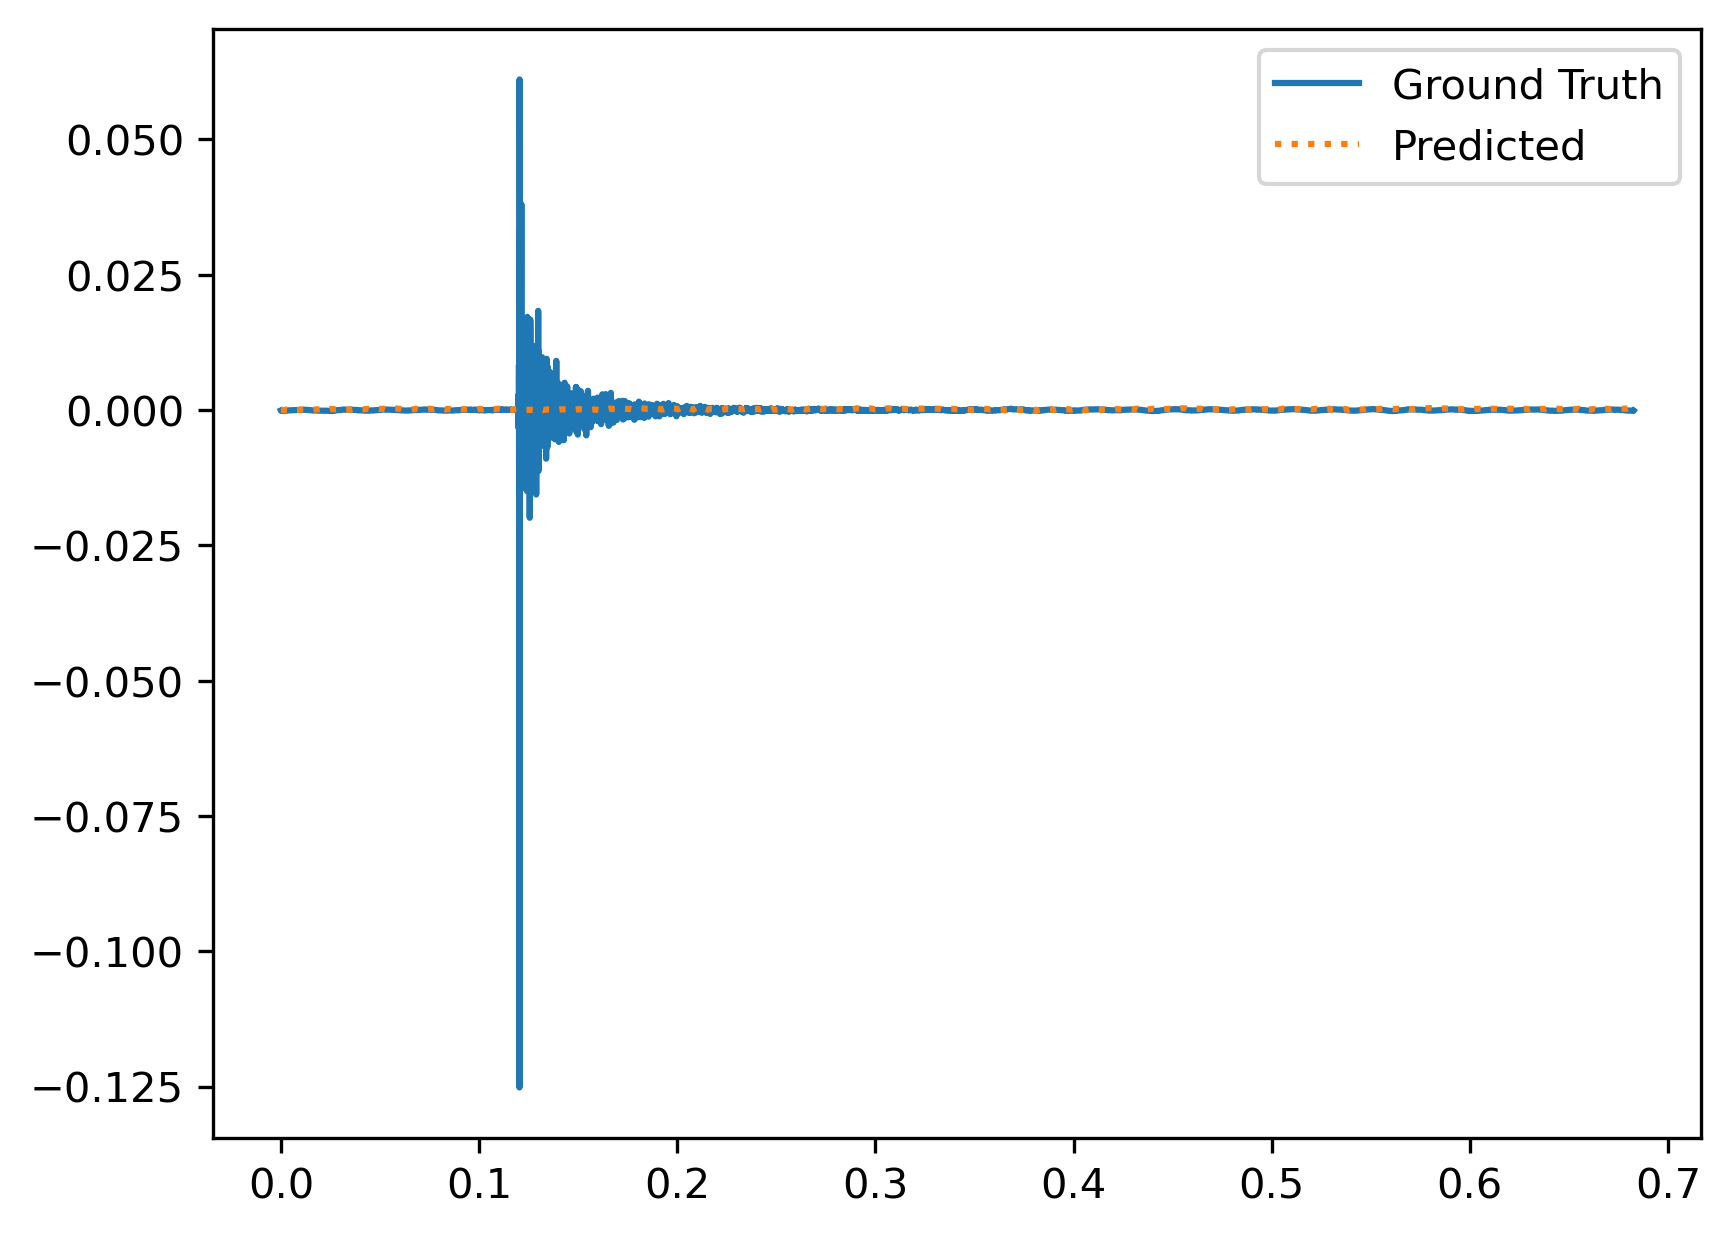

In [53]:
with torch.no_grad():
    model.eval()
    pt, tgt_gt = collate([trainset[np.random.choice(len(trainset))]])
    tgt_pred = model(pt)
    print(tgt_gt.shape)
    print(tgt_pred.shape)
    print(F.mse_loss(tgt_pred, tgt_gt))
    
    tgt_gt = tgt_gt.numpy().flatten()
    tgt_pred = tgt_pred.numpy().flatten()
    time_scale = np.linspace(0,IR_len/FS, IR_len)
    #Plot the data 
    fig, ax = plt.subplots(1)
    ax.plot(time_scale, tgt_gt, time_scale, tgt_pred, ':')
    ax.legend(['Ground Truth','Predicted'])